# **3. Batch Normalization**

Our next goal is optimizing the base model so that we can reach higher accuracies and avoid overfitting as much as possible. We will first start by increasing the complexity of the base model (i.e.: adding more layers), as well as incorporating regularization techniques to prevent us from overfitting to the training set. 

In this notebook we will explore the power of dropout for helping us reduce overfitting to the data. We will start by building a similar architecture to the one used by the base model, reusing the weights from the previously trained model. 

We will start by defining a relatively small dropout rate (0.05). Since we will be increasing the number of samples by using data augmentation later on, using a higher penalty will probably hinder the training process and ultimately causing the model to meet early stopping criteria before converging.

# Introduction

Batch normalization is a regularization technique that is used to speed up training and reduce overfitting by scaling the inputs of each layer so that they have zero mean and unit variance. This allows the inputs to preserve the same distribution accross layers, thus making the training process more stable. In order to do this, the following steps are implemented:

1. Calculate the mean and variance of the inputs over the current batch.
2. Normalize the inputs (i.e.: substract the mean and divide by the standard deviation).
3. Scale and shift the normalizes inputs using two learnable parameters ($\beta$ and $\gamma$).

<p>
    <img src="docs/batch-norm.png" width="700" height="550" />
</p>

***[Batch Norm Explained Visually — How it works, and why neural networks need it](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)***

**Sources**:

+ Ioffe, S., & Szegedy, C. (2015). Batch Normalization: [Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). arXiv preprint arXiv:1502.03167.
+ Brownlee, J. (2019) A gentle introduction to batch normalization for Deep Neural Networks, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ (Accessed: April 1, 2023). 
+ Riva, W.by: M. (2022) Batch normalization in Convolutional Neural Networks, Baeldung on Computer Science. Available at: https://www.baeldung.com/cs/batch-normalization-cnn (Accessed: April 1, 2023). 


In [27]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

Now let's see how our data is structured:

In [28]:
# Root folder
base_dir = "./data"

In [29]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [30]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [31]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Baroque', 'Realism', 'Renaissance', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Baroque       4000         500   500
Realism       4000         500   500
Renaissance   4000         500   500
Romanticism   4000         500   500


# 3.1. Model structure

Let's first create the model structure. In this case, we will be implementing batch-normalization after each convolutional layer. Also, we will not be using dropout and batch normalization together in the convolutional part of the network, as the statistics used to normalize the inputs can potentially become noisy when combining them with dropout.

In [32]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [33]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
model.add(layers.BatchNormalization())
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(256, 
                        (3, 3), 
                        activation='relu'
                        )
)
model.add(layers.BatchNormalization())
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, 
                        (3, 3), 
                        activation='relu'
                        )
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))

As we can see, in this case we implemented batch normalization after each max-pooling layer of the CNN part of the network.

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

We can appreciate this model has the number of parameters than the one used in `2-Dropout_model.ipynb`.

Once again, we'll use Adam as our optimizer. In this case, we can use a much larger learning rate, as batch normalization makes learning much more stable. This will help us speed up the overall training process.

In [35]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.03),
    metrics=['acc']
)

# 3.2. Data preprocessing

The data preprocessing applied in this case is the same as used in the previous models.

In [36]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     samplewise_center=True,
#     samplewise_std_normalization=True
    )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [37]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


# 3.3. Training


In [38]:
# Model name and path
model_path = os.path.join("models", "batch_model.h5")

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
 34/125 [=======>......................] - ETA: 6:24 - loss: 201.6859 - acc: 0.2659

c:\Users\carlo\anaconda3\envs\venv_art\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 55.8811 - acc: 0.2527
Epoch 1: val_loss improved from inf to 1.44195, saving model to models\batch_model.h5
125/125 [==============================] - 586s 5s/step - loss: 55.8811 - acc: 0.2527 - val_loss: 1.4420 - val_acc: 0.3875
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3897 - acc: 0.2499
Epoch 2: val_loss improved from 1.44195 to 1.40050, saving model to models\batch_model.h5
125/125 [==============================] - 570s 5s/step - loss: 1.3897 - acc: 0.2499 - val_loss: 1.4005 - val_acc: 0.0000e+00
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.3886 - acc: 0.2516
Epoch 3: val_loss improved from 1.40050 to 1.39653, saving model to models\batch_model.h5
125/125 [==============================] - 571s 5s/step - loss: 1.3886 - acc: 0.2516 - val_loss: 1.3965 - val_acc: 0.0000e+00
Epoch 4/30
116/125 [==========================>...] - ETA: 38s - loss: 1.3894 - acc: 0.2528

KeyboardInterrupt: 

Now let's load the best model found:

In [ ]:
# load the saved model
batch_model = load_model(model_path)

# 3.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

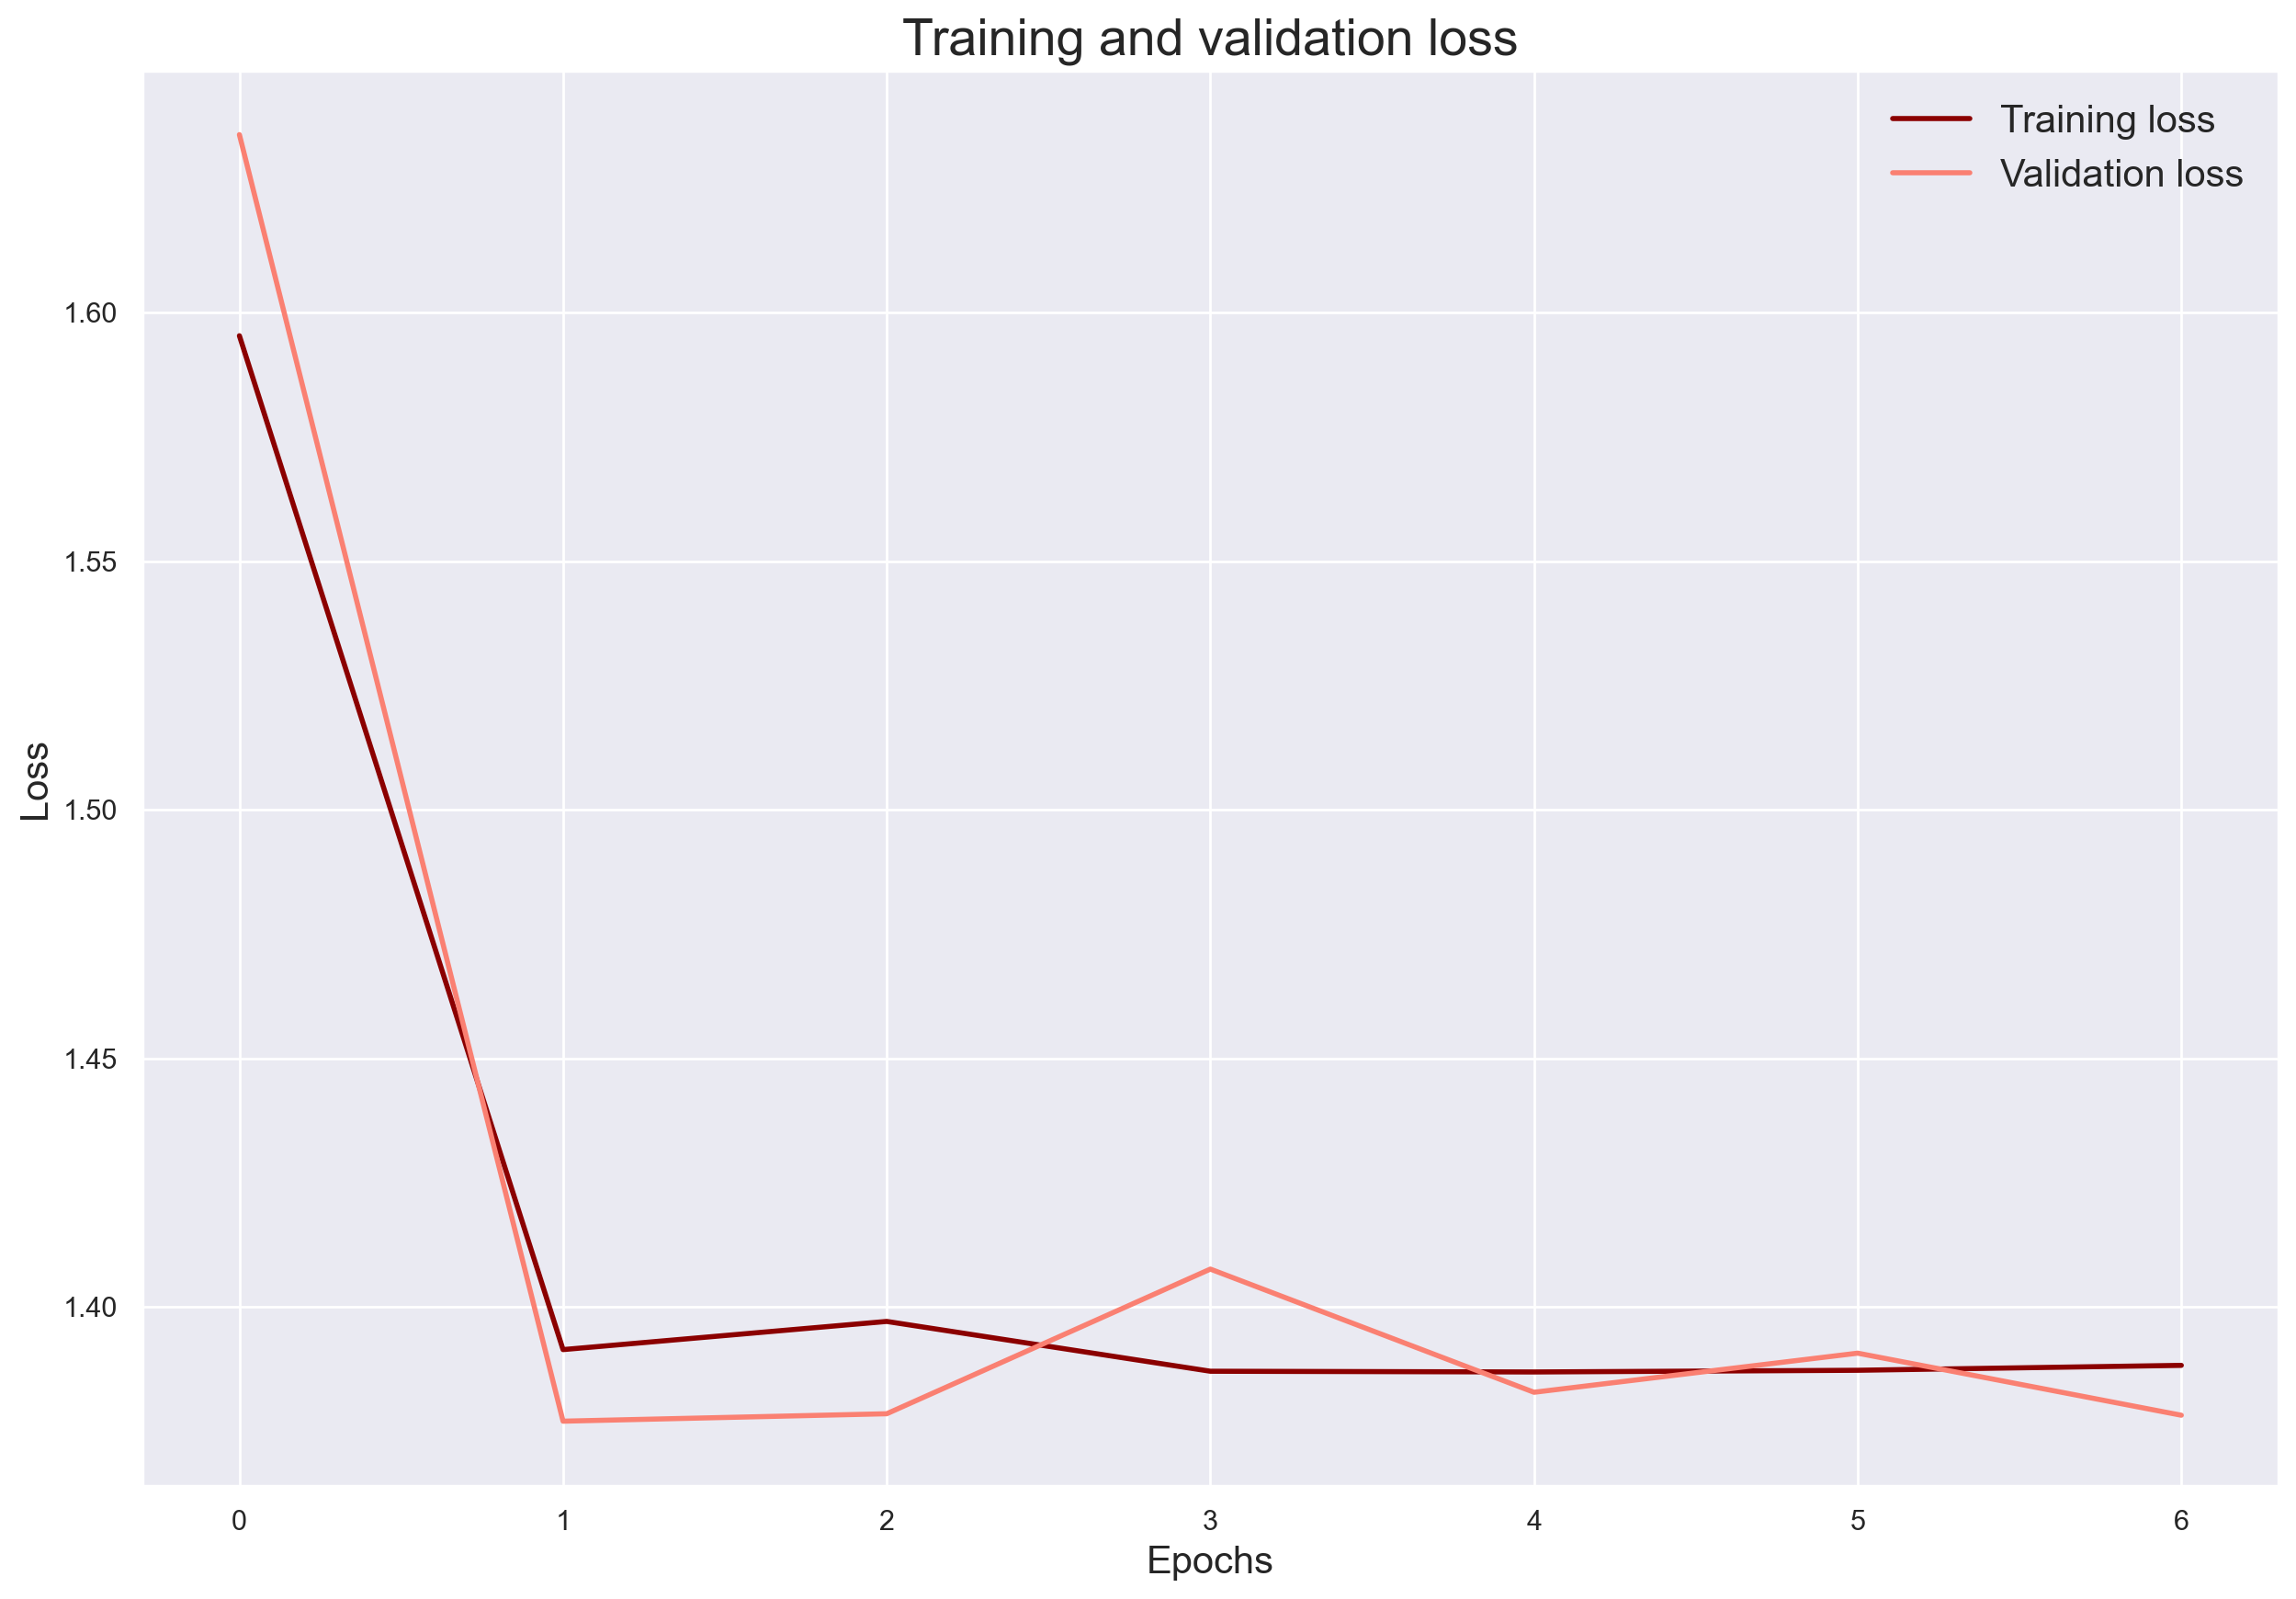

In [ ]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss")

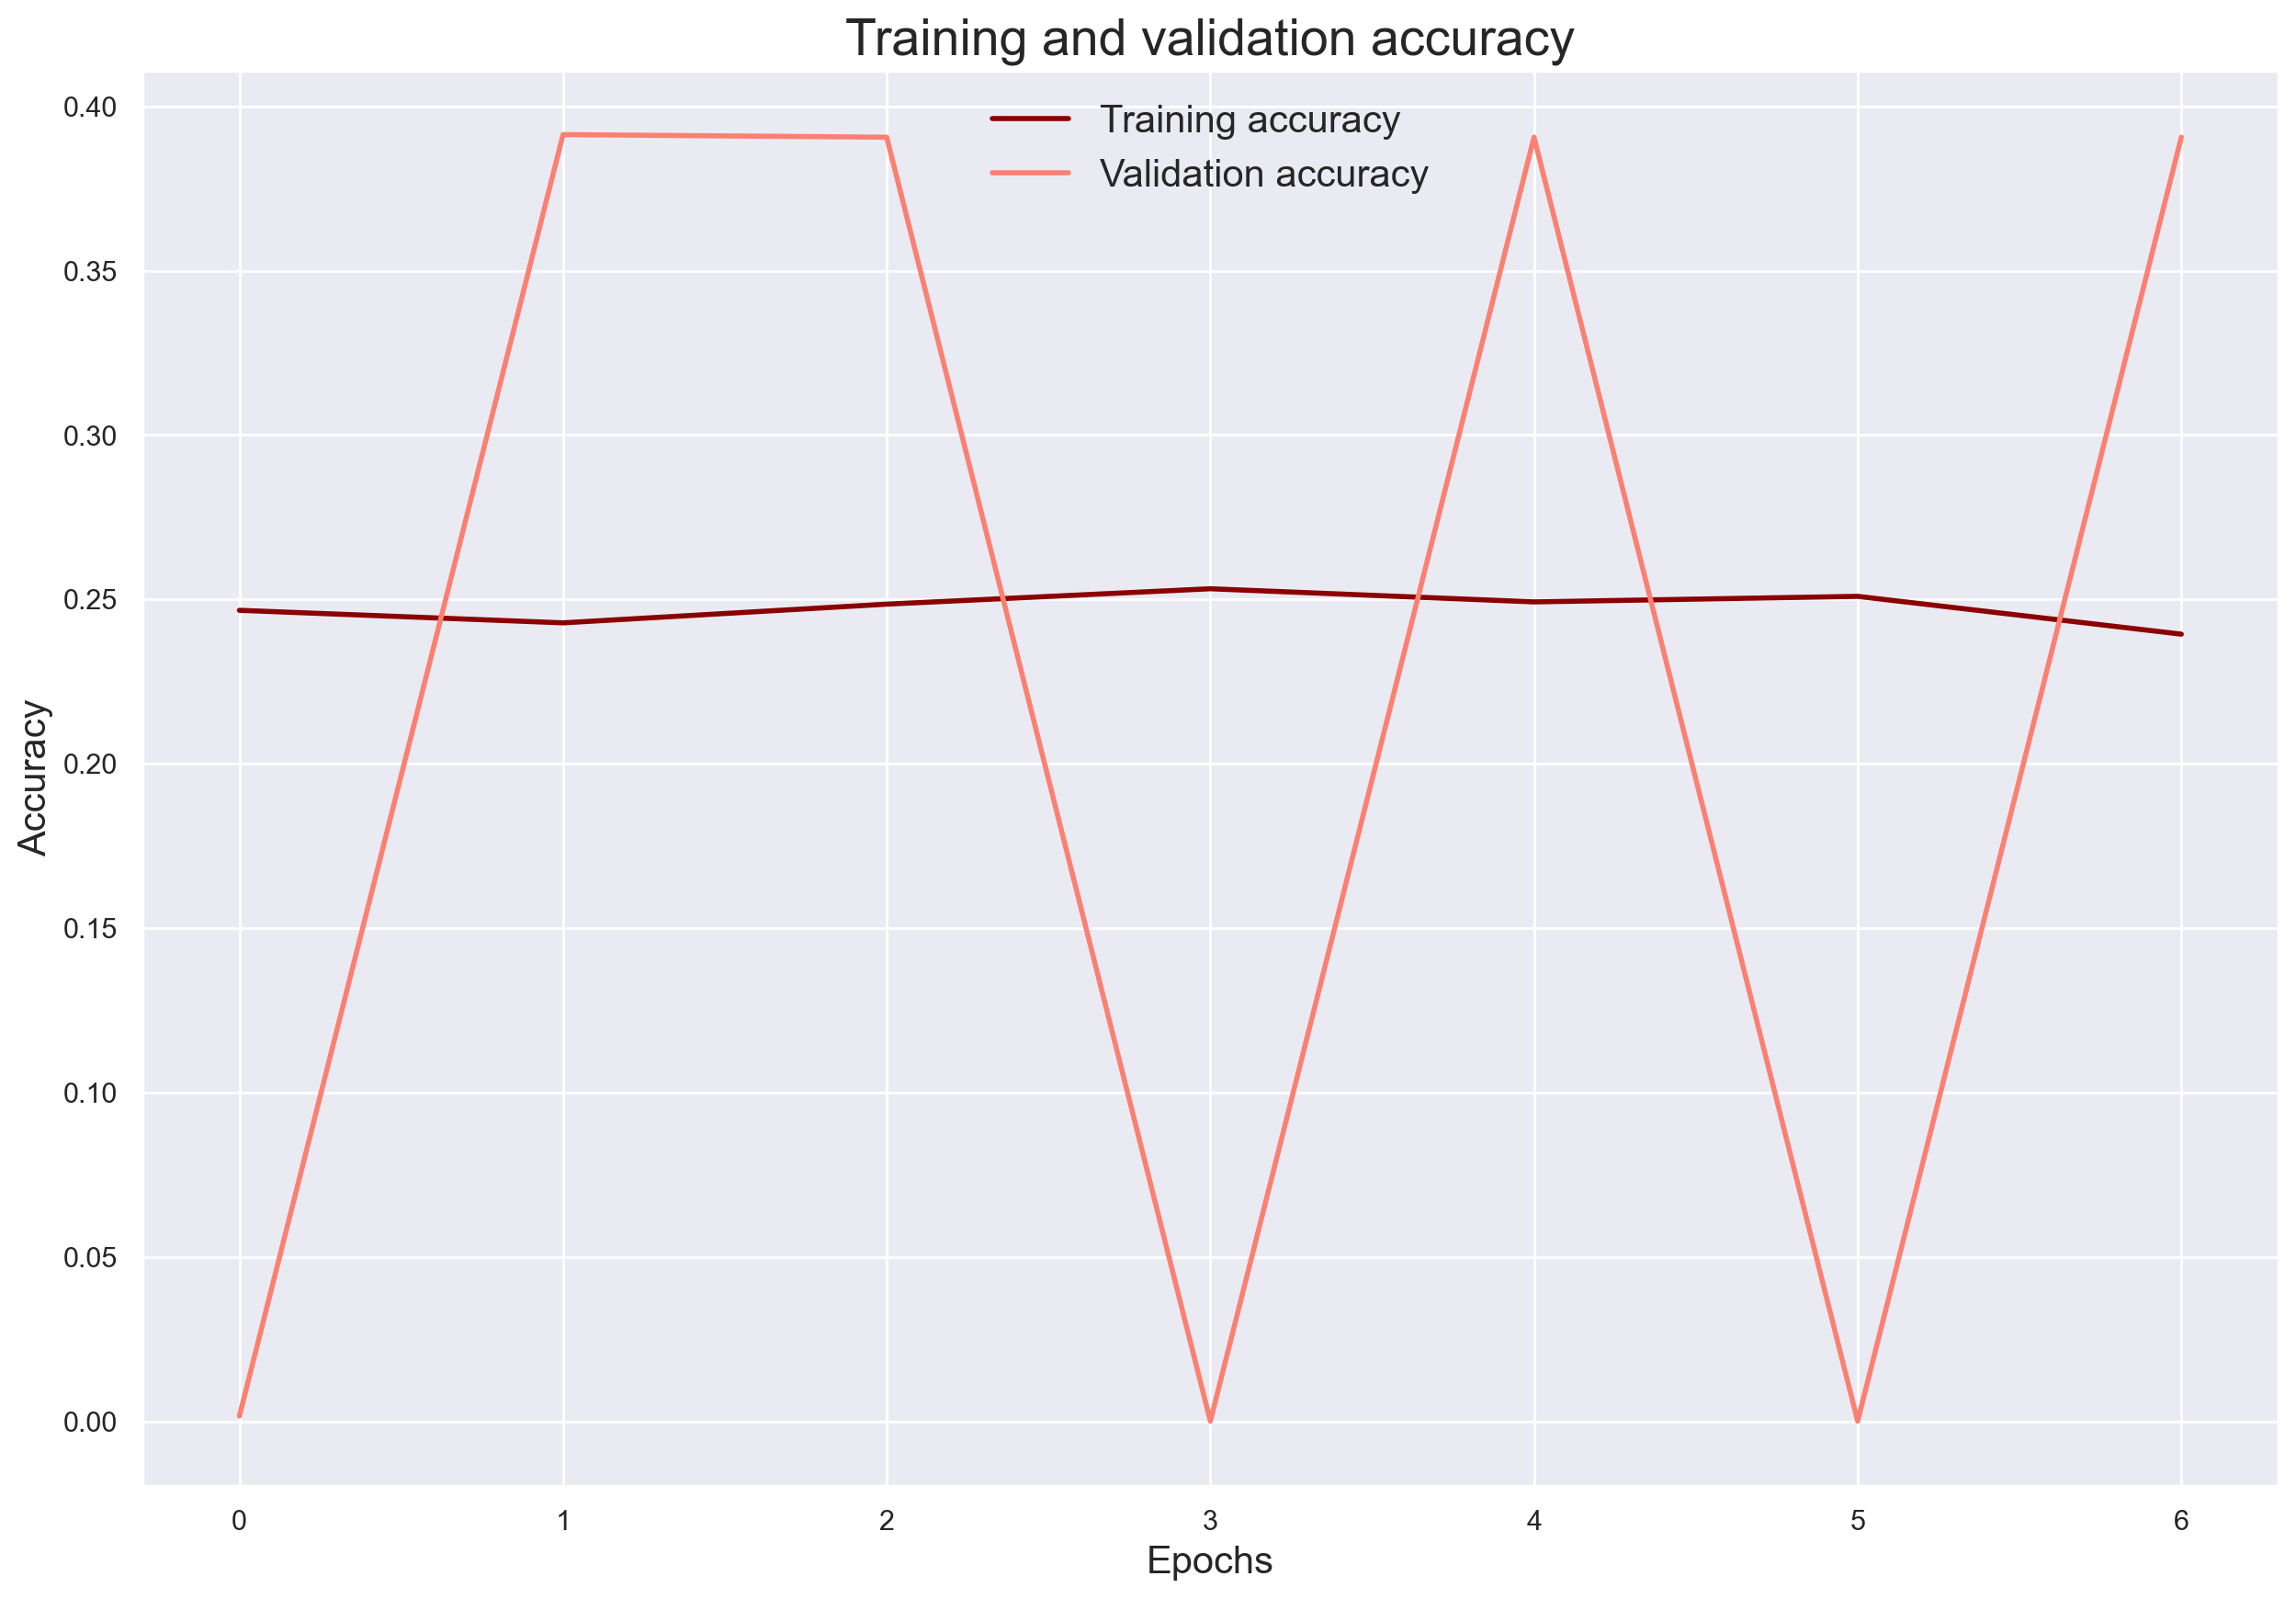

In [ ]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "Accuracy")

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
        )

Found 2000 images belonging to 4 classes.


In [ ]:
model.evaluate(test_generator)

50/50 [==============================] - 49s 983ms/step - loss: 1.3864 - acc: 0.2500


[1.3864210844039917, 0.25]

In [ ]:
batch_model.evaluate(test_generator)

50/50 [==============================] - 45s 905ms/step - loss: 1.3865 - acc: 0.2500


[1.3864541053771973, 0.25]

**Comments of how the metrics have evolved**